# 6. From Linear Regression to Logistic Regression for Binary Classification

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (25/11/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Sklearn (tested on v0.0.post1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### Before we start: the sigmoid function and the logistic/logarithm function

In this notebook, we will rely on three functions: the sigmoid function $ s(x) $, the natural logarithm (often denoted *ln*) function $ l(x) $, and its variation $ l2(x) $, which are defined below.

$$ s(x) = \frac{\exp(x)}{1 + \exp(x)} = \frac{1}{1 + \exp(-x)} $$

$$ l(x) = ln(x) $$

$$ l_2(x) = ln(1 - x) $$

Let us define and visualize these functions first.

In [2]:
def s(x):
    return 1/(1 + np.exp(-x))
def l(x):
    return np.log(x)
def l2(x):
    return np.log(1 - x)

The sigmoid function has the following properties:

$$ \forall x, \: 0 < s(x) < 1 $$

$$ \lim_{x \rightarrow -\infty} \: s(x) = 0 $$

$$ \lim_{x \rightarrow \infty} \: s(x) = 1 $$

$$ s(0) = 0.5 $$

This is confirmed, below, by displaying the sigmoid function curve for x values ranging between -10 and 10.

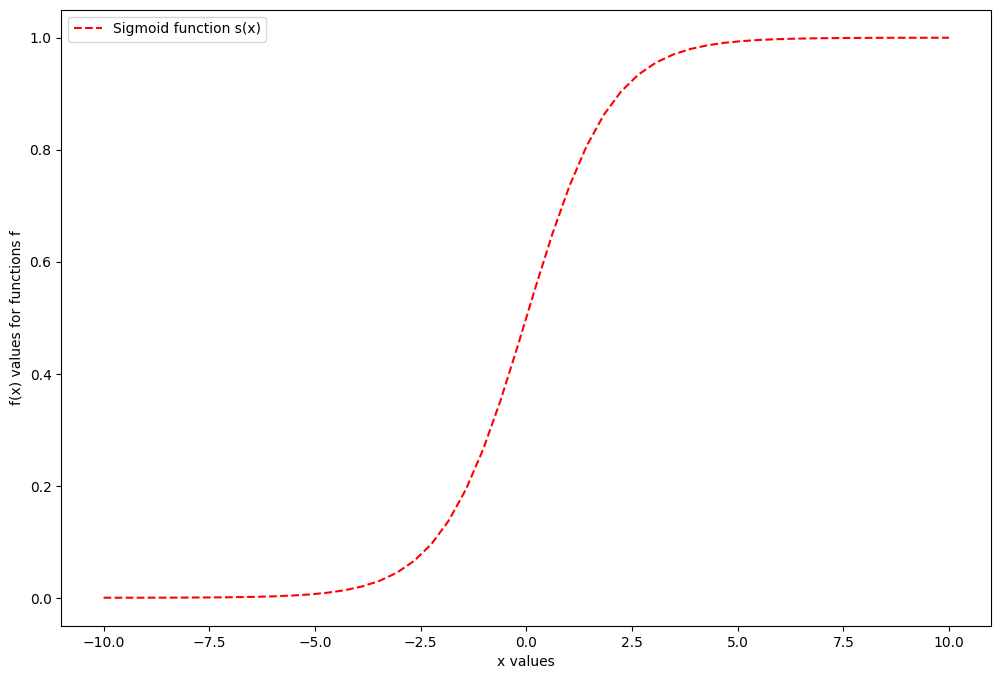

In [3]:
# Initialize matplotlib
plt.figure(figsize = (12, 8))
plt.xlabel("x values")
plt.ylabel("f(x) values for functions f")

# Sigmoid values between -10 and 10
x_val = np.linspace(-10, 10, 50)
y_val = [s(x) for x in x_val]
plt.plot(x_val, y_val, 'r--', label = "Sigmoid function s(x)")

# Display
plt.legend(loc = 'best')
plt.show()

Similarly, our two log functions, $ l(x) $ and $ l_2(x) $ have the following properties:
    
$$ \lim_{x \rightarrow 0} \: l(x) = \lim_{x \rightarrow 0} \: ln(x) = -\infty $$

$$ \lim_{x \rightarrow 1} \: l(x) = \lim_{x \rightarrow 1} \: ln(x) = 0 $$

$$ \lim_{x \rightarrow 0} \: l_2(x) = \lim_{x \rightarrow 1} \: ln(1 - x) = 0 $$

$$ \lim_{x \rightarrow 1} \: l_2(x) = \lim_{x \rightarrow 1} \: ln(1 - x) = -\infty $$

$$ l(0.5) = l_2(0.5) = -ln(2) \approx -0.6931 $$

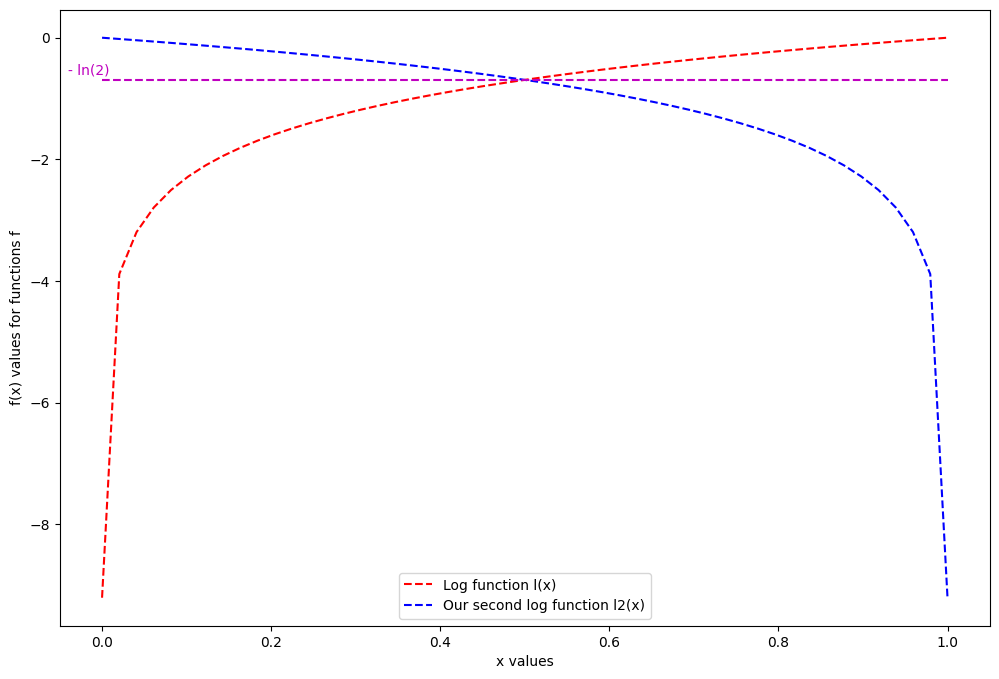

In [27]:
# Initialize matplotlib
plt.figure(figsize = (12, 8))
plt.xlabel("x values")
plt.ylabel("f(x) values for functions f")

# Log l(x) values between 0 and 1
eps = 1e-4
x_val = np.linspace(eps, 1 - eps, 50)
y_val1 = [l(x) for x in x_val]
plt.plot(x_val, y_val1, 'r--', label = "Log function l(x)")

# Log l2(x) values between 0 and 1
y_val2 = [l2(x) for x in x_val]
plt.plot(x_val, y_val2, 'b--', label = "Our second log function l2(x)")

# Interest line
plt.plot(x_val, [-np.log(2) for _ in range(len(x_val))], "m--")
plt.text(-0.04, -np.log(2) + 0.1, "- ln(2)", {"color": "m"})

# Display
plt.legend(loc = 'best')
plt.show()

In addition,the following properties hold (some of them require using L'Hospital rule to prove them).

$$ \lim_{x \rightarrow 1} \: (1 - x) \: ln(1 - x) = \lim_{x \rightarrow 0} \: x \: ln(x) = 0 $$

$$ \lim_{x \rightarrow 0} \: (1 - x) \: ln(1 - x) = \lim_{x \rightarrow 1} \: x \: ln(x) = 0 $$

We can also study the following properties (crossing x and (1-x) in and out of the ln).

$$ \lim_{x \rightarrow 0} \: (1 - x) \: ln(x) = \lim_{x \rightarrow 1} \: x \: ln (1 - x) = -\infty $$

$$ \lim_{x \rightarrow 1} \: (1 - x) \: ln(x) = \lim_{x \rightarrow 0} \: x \: ln(1 - x) = 0 $$

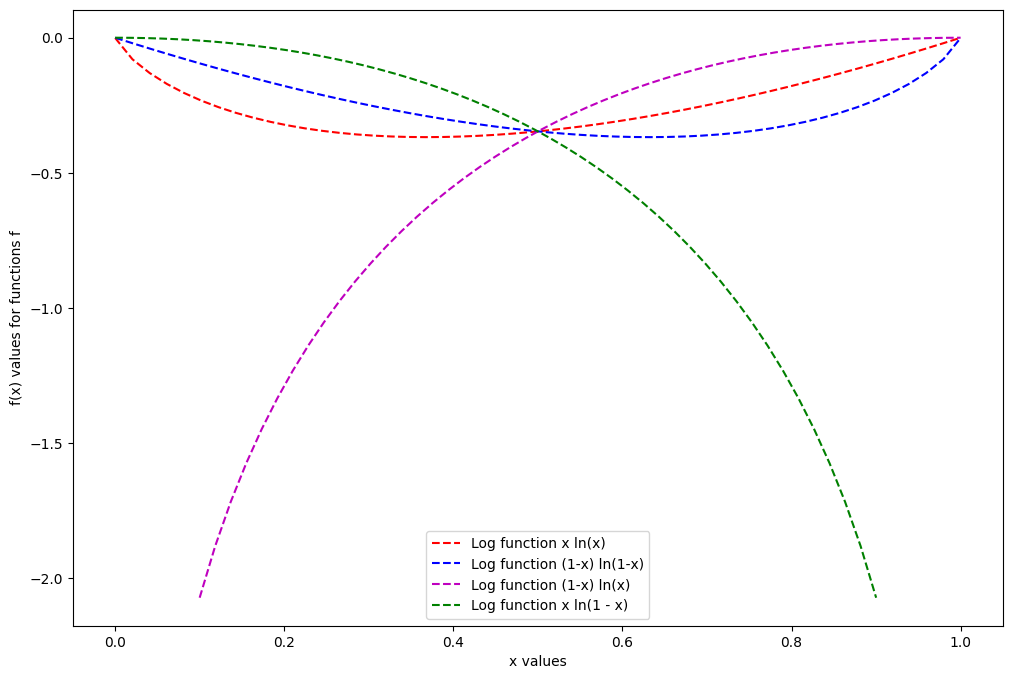

In [5]:
# Initialize matplotlib
plt.figure(figsize = (12, 8))
plt.xlabel("x values")
plt.ylabel("f(x) values for functions f")

# Log xl(x) values between 0 and 1
eps = 1e-4
x_val = np.linspace(eps, 1 - eps, 50)
y_val1 = [x*l(x) for x in x_val]
plt.plot(x_val, y_val1, 'r--', label = "Log function x ln(x)")

# Log (1-x)l2(x) values between 0 and 1
y_val2 = [(1 - x)*l2(x) for x in x_val]
plt.plot(x_val, y_val2, 'b--', label = "Log function (1-x) ln(1-x)")

# Log (1-x)l(x) values between 0 and 1
eps2 = 0.1
x_val2 = np.linspace(eps2, 1 - eps, 50)
y_val3 = [(1 - x)*l(x) for x in x_val2]
plt.plot(x_val2, y_val3, 'm--', label = "Log function (1-x) ln(x)")

# Log xl2(x) values between 0 and 1
x_val3 = np.linspace(eps, 1 - eps2, 50)
y_val4 = [x*l2(x) for x in x_val3]
plt.plot(x_val3, y_val4, 'g--', label = "Log function x ln(1 - x)")

# Display
plt.legend(loc = 'best')
plt.show()

### Mock dataset generation

In this notebook, we will prepare a dataset for a single-variable binary classification.
- The inputs, **x**, will consist of chest sizes for male between 94cm and 114cm, randomly generated.
- The outputs, **y**, will consists of two classes, corrsesponding to the shirt size to use, namely M (class 0, if chest size is below 104 cm) size and L size (class 1, if chest size is above 104 cm).

Below, we define the helper functions which will serve to produce this mock dataset.

In [6]:
# All helper functions
def chest_size(min_size, max_size):
    return round(np.random.uniform(min_size, max_size), 2)
def shirt_size(size, threshold):
    return int(size >= threshold)
def generate_datasets(n_points, min_size, max_size, threshold):
    x = np.array([chest_size(min_size, max_size) for _ in range(n_points)])
    y = np.array([shirt_size(i, threshold) for i in x])
    return x, y

In [7]:
# Dataset generation (n_points points will be generated).
# We will use a seed for reproducibility.
min_size = 94
max_size = 114
threshold = 104
np.random.seed(27)
n_points = 50
inputs, outputs = generate_datasets(n_points, min_size, max_size, threshold)
print(inputs)
print(outputs)

[102.51 110.29 108.71 111.36 101.67 113.59 111.86  98.19 108.84 107.26
 111.74 111.16 108.99 111.4   97.74 100.51 101.46 109.87  97.02  97.4
  95.62 100.1  109.67  97.26  95.41 108.02  97.62 105.98 102.31 104.27
  98.41 108.51 110.99 112.58 108.72 103.53 103.86 105.89  95.52  96.35
 113.33 105.67  95.85  94.27 110.74 112.3  108.09 101.74 108.11 112.47]
[0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0
 1 0 0 1 1 0 0 1 1 1 0 1 1]


### Displaying our dataset

Below, we display our dataset, for visualization.

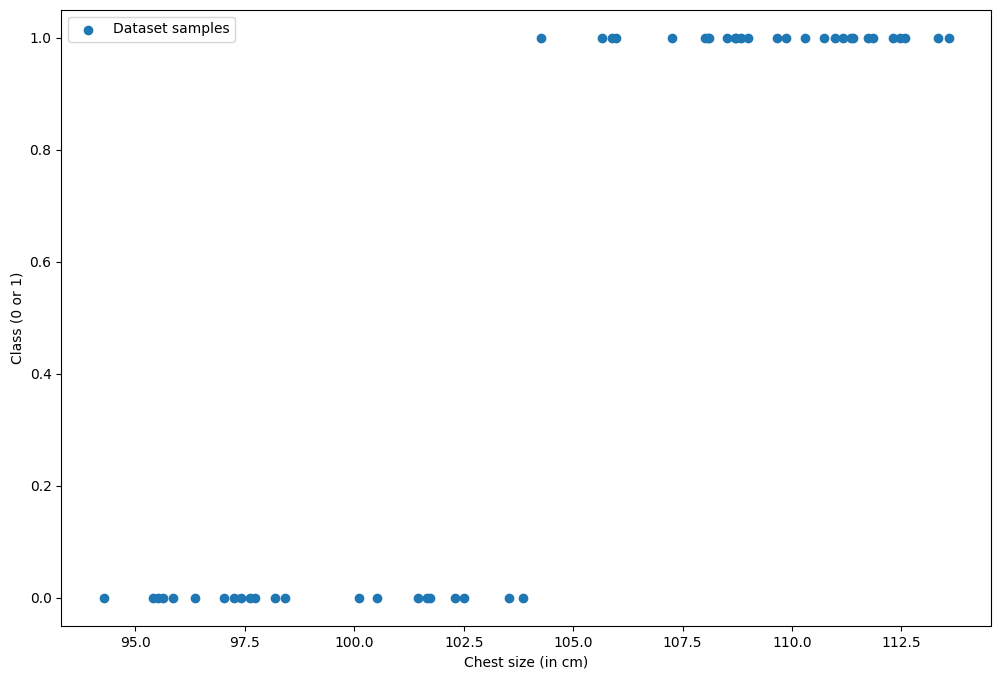

In [8]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(inputs, outputs, label = 'Dataset samples')
plt.xlabel("Chest size (in cm)")
plt.ylabel("Class (0 or 1)")

# Display
plt.legend(loc = 'best')
plt.show()

### Logistic regression

The logistic regression model assumes that the classes $ y_i $ for every sample $ x_i $ are connected via the formula below.

$$ \forall i \in \{1, 2, ..., N\}, \: y_i = \left\{ \begin{array}{ll} 0 & \text{if } p(x_i) > 0.5 \text{,} \\ 1 & \text{otherwise.} \end{array} \right. $$

The function $ p(x) $ has a value between 0 and 1, thanks to the sigmoid function $ s $ we defined earlier. This value $ p(x) $ is often refered to as the **probability** of sample with value $ x $ being of class 1 (that is L size). Respectively, $ 1 - p(x) $ is therefore the **probability** of sample with value $ x $ being of class 0 (that is M size).

$$ \forall x, \: p(x) = s(a x + b) = \frac{\exp(a x + b)}{1 + \exp(a x + b)}. $$

This model has two parameters, $ a $ and $ b $, to be decided like in the linear regression.

In addition, note that the function $ f(x) = a x + b $ is also often refered to as the **logit** function with value $ x $.

Our logistic regression function is defined below. We also provide two additional helper functions to generate predictions using our model and inputs, and to display the logistic regression on matplotlib.

In [9]:
def logistic_regression(x, a, b):
    return s(a*x + b)
def predict_samples(inputs, a, b):
    return [int(logistic_regression(x, a, b) >= 0.5) for x in inputs]
def logistic_regression_matplotlib(a, b, min_size, max_size):
    x_plt = np.linspace(min_size, max_size, 50)
    y_plt = [s(a*x + b) for x in x_plt]
    return x_plt, y_plt

In [10]:
# Trying to predict with our logistic regression
# model, for two given values of a and b.
a = 1.7
b = -172
pred_y = predict_samples(inputs, a, b)
print(pred_y)

[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


### Logistic regression visualization

Below, we display two models and their predictions areas, for two sets of values of $ a $ and $ b $.

The first model misclassifies some samples (red crosses not matching the blue samples).

The second one is a perfect model (you should recognize some values we used during the mock dataset generation!)

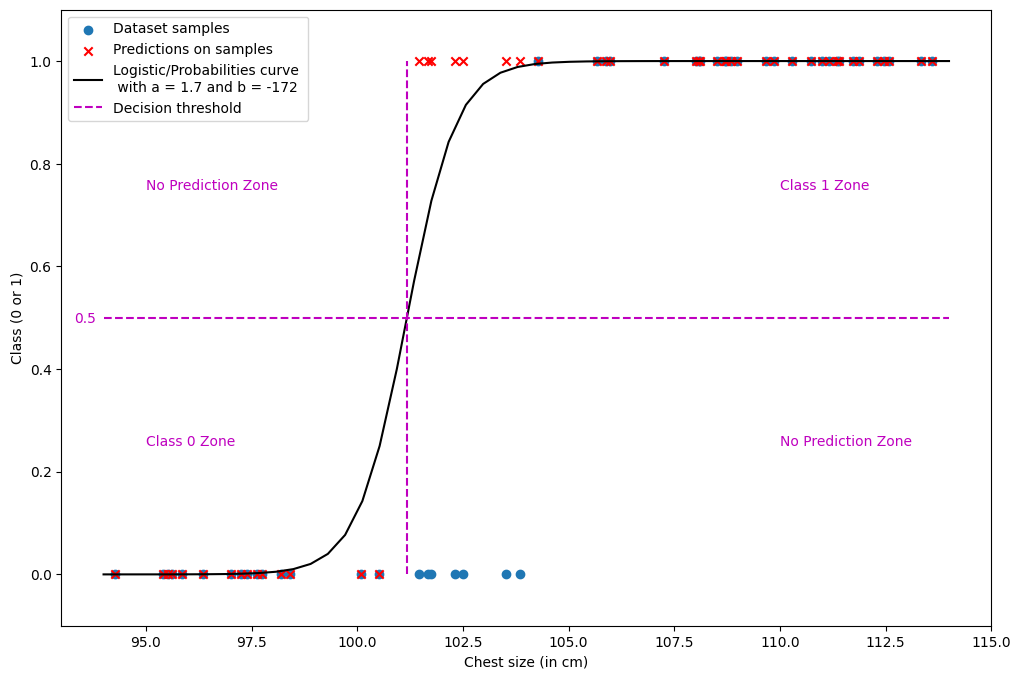

In [11]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(inputs, outputs, label = 'Dataset samples')
plt.xlabel("Chest size (in cm)")
plt.ylabel("Class (0 or 1)")

# Display predictions for our model
a1 = 1.7
b1 = -172
pred_y = predict_samples(inputs, a1, b1)
plt.scatter(inputs, pred_y, c = 'r', marker = "x", label = 'Predictions on samples')

# Display logistic regression curve and threshold curves
x_plt, y_plt = logistic_regression_matplotlib(a1, b1, min_size, max_size)
plt.plot(x_plt, y_plt, "k", label = "Logistic/Probabilities curve \n with a = {} and b = {}".format(a1, b1))
plt.plot(x_plt, [0.5 for _ in x_plt], "m--", label = "Decision threshold")
plt.plot([-b1/a1 for _ in range(50)], np.linspace(0, 1, 50), "m--")
plt.text(110, 0.75, "Class 1 Zone", {"color": "m"})
plt.text(95, 0.25, "Class 0 Zone", {"color": "m"})
plt.text(110, 0.25, "No Prediction Zone", {"color": "m"})
plt.text(95, 0.75, "No Prediction Zone", {"color": "m"})
plt.text(93.3, 0.49, "0.5", {"color": "m"})

# Display
plt.legend(loc = 'best')
plt.ylim([-0.1, 1.1])
plt.show()

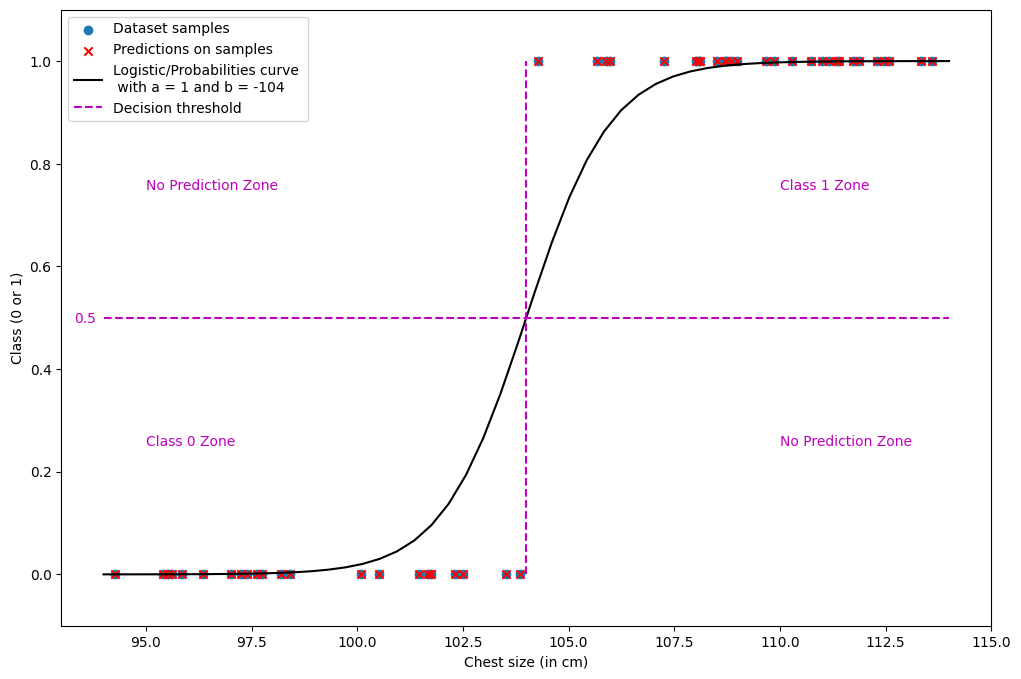

In [12]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(inputs, outputs, label = 'Dataset samples')
plt.xlabel("Chest size (in cm)")
plt.ylabel("Class (0 or 1)")

# Display predictions for our model
a2 = 1
b2 = -104
pred_y = predict_samples(inputs, a2, b2)
plt.scatter(inputs, pred_y, c = 'r', marker = "x", label = 'Predictions on samples')

# Display logistic regression curve and threshold curves
x_plt, y_plt = logistic_regression_matplotlib(a2, b2, min_size, max_size)
plt.plot(x_plt, y_plt, "k", label = "Logistic/Probabilities curve \n with a = {} and b = {}".format(a2, b2))
plt.plot(x_plt, [0.5 for _ in x_plt], "m--", label = "Decision threshold")
plt.plot([-b2/a2 for _ in range(50)], np.linspace(0, 1, 50), "m--")
plt.text(110, 0.75, "Class 1 Zone", {"color": "m"})
plt.text(95, 0.25, "Class 0 Zone", {"color": "m"})
plt.text(110, 0.25, "No Prediction Zone", {"color": "m"})
plt.text(95, 0.75, "No Prediction Zone", {"color": "m"})
plt.text(93.3, 0.49, "0.5", {"color": "m"})

# Display
plt.legend(loc = 'best')
plt.ylim([-0.1, 1.1])
plt.show()

### Defining a loss function for the logisitic regression

When playing with the linear regression, we used the Mean Square Error as a loss function, to measure the quality of a model and its choice of parameters for $ a $ and $ b $.

In the case of logistic regression, we prefer to use a different loss function, namely the **log-likelihood function**.

$$ \begin{array}{ll} L(x, y, a, b) & = \displaystyle \frac{1}{N} \sum_{i = 1}^N \: y_i \: l\big(p(x_i)\big) \: + \: (1- y_i) \: l_2\big(p(x_i)\big) \\
 & = \displaystyle \frac{1}{N} \sum_{i = 1}^N \: y_i \: ln\big(p(x_i)\big) \: + \: (1- y_i) \: ln\big(1 - p(x_i)\big) \end{array} $$
 
 Note that thanks to the sigmoid function, we have $ \forall x_i, 0 < p(x_i) < 1 $ and therefore no mathematical problems occur in the two natural logarithm functions in **log-likelihood** loss function above.
 
 This is a good loss function to use for our problem for the two reasons:
 - When $ p(x_i) $ is close to the ground truth value $ y_i $, both terms of the loss function, namely $ y_i \: ln\big(p(x_i)\big) $ and $ (1- y_i) \: ln\big(1 - p(x_i)\big) $ will have values close to 0. This follows from the properties we defined earlier for the functions $ l $ and $ l_2 $.
 - On the opposite, the **log-likelihood** loss function will have a different behavior when $ p(x_i) $ and the ground truth value $ y_i $ are different, for instance when $ p(x_i) \approx 0 $ (resp. $ p(x_i) \approx 1 $) and the ground truth value $ y_i $ is 1 (resp. 0). In both cases, the terms of the **log-likelihood** loss function, namely $ y_i \: ln\big(p(x_i)\big) $ and $ (1- y_i) \: ln\big(1 - p(x_i)\big) $, will have non-zero negative values.
 
This **log-likelihood** loss function is therefore a good choice of a performance metric to measure the performance of our models. Indeed, maximizing this **log-likelihood** loss function and bringing it as close as possible to zero would be equivalent to finding the best choice of parameters $ a $ and $ b $ and therefore the best fit.

(***Quick note:*** in **linear regression**, we would **minimize** the **MSE loss**; in logistic regression, we **maximize** the **log-likelihood** function instead. This has to do with the behavior of both functions and the fact that for the **log-likelihood** loss, we always get negative values and closer to 0 is better; whereas MSE behaved in the opposite way.)

In other words, we are looking for the optimal parameters $ a^* $ and $ b^* $ such that:

$$ a^*, b^* = \arg \max_{a, b} \left[\displaystyle \frac{1}{N} \sum_{i = 1}^N \: y_i \: ln\big(p(x_i)\big) \: + \: (1- y_i) \: ln\big(1 - p(x_i)\big) \right] $$

While this looks like an optimization with a convex function and we feel that it could be solved analytically, like we did with linear regression in Notebook 1, this optimization problem is, however, deceptively difficult to solve.

In fact, it is often impossible to solve it analytically (apart, maybe, for cases with trivial datasets), and we will prefer heuristical methods, to try and find parameters $ a^* $ and $ b^* $. Possible methods include gradient-descent types of methods like in Notebook 2, or the Newton's method as demonstrated later. While the implementation of these heuristic optimization methods for logistic regression are out of scope, we invite the curious reader to learn more, here: https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch12.pdf.

The best we can do for now is therefore to implement the **log-likelihood** loss function and try it on our two models, below.

In [30]:
def log_likelihood_loss(a, b, x, y):
    # Using Numpy broadcasting
    return np.mean(y*np.log(logistic_regression(x, a, b)) \
                   + (1 - y)*np.log(1 - logistic_regression(x, a, b)))

As expected, our first model has a loss value that is lower than our second model, indicating that the second model is a better fit than the first one.

Feel free to try playing with the parameters $ a $ and $ b $ to check if you can find a better choice of parameters, with a better loss value than $ -0.05944817647128179 $!

In [14]:
# Loss for model 1, using a1 = 1.7 and b1 = -172
loss1 = log_likelihood_loss(a1, b1, inputs, outputs)
# Loss for model 2, using a2 = 1 and b2 = -104
loss2 = log_likelihood_loss(a2, b2, inputs, outputs)
print(loss1, loss2)

-0.33846089021766784 -0.05944817647128179


### Implementing logistic regression with sklearn

As before, it is often preferable to use the sklearn library to implement the Logistic Regression quickly: this is simply done by using the LogisticRegression() object, as demonstrated below.

In [15]:
# Reshaping inputs as a 2D array
# (As before, this is a requirement for sklearn models)
inputs_re = inputs.reshape(-1, 1)

# Create a logistic regression model, use the Newton method
# to find the best parameters a and b
logreg_model = LogisticRegression(solver = 'newton-cg')
logreg_model.fit(inputs_re, outputs)

# Test your model and inputs
pred_outputs = logreg_model.predict(inputs_re)
print(pred_outputs)
print(outputs)

# Retrieving coefficients a and b
a_sk = logreg_model.coef_[0, 0]
b_sk = logreg_model.intercept_[0]
print(a_sk, b_sk)

[0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0
 1 0 0 1 1 0 0 1 1 1 0 1 1]
[0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0
 1 0 0 1 1 0 0 1 1 1 0 1 1]
1.413470868291155 -147.3822278881603


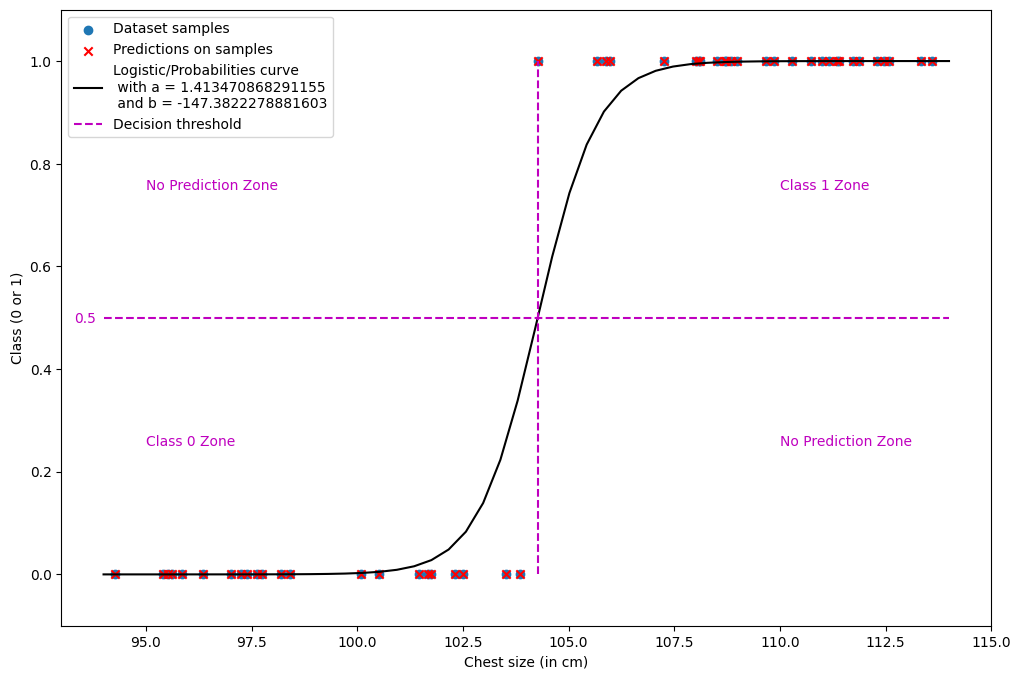

In [29]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(inputs, outputs, label = 'Dataset samples')
plt.xlabel("Chest size (in cm)")
plt.ylabel("Class (0 or 1)")

# Display predictions for our model
pred_y = predict_samples(inputs, a_sk, b_sk)
plt.scatter(inputs, pred_y, c = 'r', marker = "x", label = 'Predictions on samples')

# Display logistic regression curve and threshold curves
x_plt, y_plt = logistic_regression_matplotlib(a_sk, b_sk, min_size, max_size)
legend = "Logistic/Probabilities curve \n with a = {}\n and b = {}".format(a_sk, b_sk)
plt.plot(x_plt, y_plt, "k", label = legend)
plt.plot(x_plt, [0.5 for _ in x_plt], "m--", label = "Decision threshold")
plt.plot([-b_sk/a_sk for _ in range(50)], np.linspace(0, 1, 50), "m--")
plt.text(110, 0.75, "Class 1 Zone", {"color": "m"})
plt.text(95, 0.25, "Class 0 Zone", {"color": "m"})
plt.text(110, 0.25, "No Prediction Zone", {"color": "m"})
plt.text(95, 0.75, "No Prediction Zone", {"color": "m"})
plt.text(93.3, 0.49, "0.5", {"color": "m"})

# Display
plt.legend(loc = 'best')
plt.ylim([-0.1, 1.1])
plt.show()

In [17]:
# Loss for model 2, using a2 = 1 and b2 = -104
loss2 = log_likelihood_loss(a2, b2, inputs, outputs)
# Loss for sklearn model, using a2 = 1.413470868291155 and b2 = -147.3822278881603
loss_sk = log_likelihood_loss(a_sk, b_sk, inputs, outputs)
print(loss2, loss_sk)

-0.05944817647128179 -0.04019285099265483


In [18]:
# Using a confusion matrix.
print(confusion_matrix(outputs, pred_outputs))

[[22  0]
 [ 0 28]]


In [19]:
# Using a classification report.
print(classification_report(outputs, pred_outputs))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        28

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [20]:
# By the way, something somewhat remarkable happens here, why?
print(-b2/a2, -b_sk/a_sk)

104.0 104.26973147762224
